In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.utils.data as loader
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [0]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [0]:
in_vect_size = 200

In [4]:
class generator(nn.Module):
    """
    Generator for 3D-GAN-
    The generator consists of five fully convolution layers with numbers of channels
    {512, 256, 128, 64, 1}, kernel sizes {4, 4, 4, 4, 4}, and strides {1, 2, 2, 2, 2}. 
    We add ReLU and batch normalization layers between convolutional layers, and a Sigmoid
    layer at the end. The input is a 200-dimensional vector, and the output is a 64 × 64 × 64 
    matrix with values in [0, 1].
    """
    def __init__(self):
        super().__init__()
        self.layer1=nn.Sequential(
            nn.ConvTranspose3d(in_channels=200,out_channels=512,kernel_size=3,stride=1),
            nn.BatchNorm3d(512),
            nn.ReLU(),
        )
        self.layer2=nn.Sequential(
            nn.ConvTranspose3d(in_channels=512,out_channels=256,kernel_size=3,stride=2),
            nn.BatchNorm3d(256),
            nn.ReLU(),
        )
        self.layer3=nn.Sequential(
            nn.ConvTranspose3d(in_channels=256,out_channels=128,kernel_size=3,stride=2),
            nn.BatchNorm3d(128),
            nn.ReLU(),
        )
        self.layer4=nn.Sequential(
            nn.ConvTranspose3d(in_channels=128,out_channels=64,kernel_size=3,stride=2),
            nn.BatchNorm3d(64),
            nn.ReLU(),
        )
        self.layer5=nn.Sequential(
            nn.ConvTranspose3d(in_channels=64,out_channels=1,kernel_size=4,stride=2),
            nn.Sigmoid(),
        )
    
    def forward(self,x):
        bsize=x.size(0)
        x=x.view(bsize,in_vect_size,1,1,1)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        return x
G_=generator().to(device)
summary(G_,(1,in_vect_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose3d-1         [-1, 512, 3, 3, 3]       2,765,312
       BatchNorm3d-2         [-1, 512, 3, 3, 3]           1,024
              ReLU-3         [-1, 512, 3, 3, 3]               0
   ConvTranspose3d-4         [-1, 256, 7, 7, 7]       3,539,200
       BatchNorm3d-5         [-1, 256, 7, 7, 7]             512
              ReLU-6         [-1, 256, 7, 7, 7]               0
   ConvTranspose3d-7      [-1, 128, 15, 15, 15]         884,864
       BatchNorm3d-8      [-1, 128, 15, 15, 15]             256
              ReLU-9      [-1, 128, 15, 15, 15]               0
  ConvTranspose3d-10       [-1, 64, 31, 31, 31]         221,248
      BatchNorm3d-11       [-1, 64, 31, 31, 31]             128
             ReLU-12       [-1, 64, 31, 31, 31]               0
  ConvTranspose3d-13        [-1, 1, 64, 64, 64]           4,097
          Sigmoid-14        [-1, 1, 64,

In [5]:
class discriminator(nn.Module):
    """
    Discriminator for 3D-GAN-
    As a mirrored version of the generator, the discriminator takes as input a 
    64 × 64 × 64 matrix, and outputs a real number in [0, 1]. The discriminator 
    consists of 5 volumetric convolution layers, with numbers of channels {64,128,256,512,1}, 
    kernel sizes {4,4,4,4,4}, and strides {2, 2, 2, 2, 1}. There are leaky ReLU layers of 
    parameter 0.2 and batch normalization layers in between, and a Sigmoid layer at the end.
    """
    def __init__(self):
        super().__init__()
        self.layer1=nn.Sequential(
            nn.Conv3d(in_channels=1,out_channels=64,kernel_size=4,stride=2),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2)
        )
        self.layer2=nn.Sequential(
            nn.Conv3d(in_channels=64,out_channels=128,kernel_size=4,stride=2),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2)
        )
        self.layer3=nn.Sequential(
            nn.Conv3d(in_channels=128,out_channels=256,kernel_size=4,stride=2),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2)
        )
        self.layer4=nn.Sequential(
            nn.Conv3d(in_channels=256,out_channels=512,kernel_size=4,stride=2),
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2)
        )
        self.layer5=nn.Sequential(
            nn.Conv3d(in_channels=512,out_channels=1,kernel_size=2,stride=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        bsize=x.size(0)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        x=x.view(bsize,1)
        return x
D_=discriminator().to(device)
summary(D_,(1,64,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 31, 31, 31]           4,160
       BatchNorm3d-2       [-1, 64, 31, 31, 31]             128
         LeakyReLU-3       [-1, 64, 31, 31, 31]               0
            Conv3d-4      [-1, 128, 14, 14, 14]         524,416
       BatchNorm3d-5      [-1, 128, 14, 14, 14]             256
         LeakyReLU-6      [-1, 128, 14, 14, 14]               0
            Conv3d-7         [-1, 256, 6, 6, 6]       2,097,408
       BatchNorm3d-8         [-1, 256, 6, 6, 6]             512
         LeakyReLU-9         [-1, 256, 6, 6, 6]               0
           Conv3d-10         [-1, 512, 2, 2, 2]       8,389,120
      BatchNorm3d-11         [-1, 512, 2, 2, 2]           1,024
        LeakyReLU-12         [-1, 512, 2, 2, 2]               0
           Conv3d-13           [-1, 1, 1, 1, 1]           4,097
          Sigmoid-14           [-1, 1, 

In [0]:
# binvox_rw package, just because cannot upload the file always. In original it will be kept as binvox_rw.py .

In [0]:
class Voxels(object):
    """ Holds a binvox model.
    data is either a three-dimensional numpy boolean array (dense representation)
    or a two-dimensional numpy float array (coordinate representation).
    dims, translate and scale are the model metadata.
    dims are the voxel dimensions, e.g. [32, 32, 32] for a 32x32x32 model.
    scale and translate relate the voxels to the original model coordinates.
    To translate voxel coordinates i, j, k to original coordinates x, y, z:
    x_n = (i+.5)/dims[0]
    y_n = (j+.5)/dims[1]
    z_n = (k+.5)/dims[2]
    x = scale*x_n + translate[0]
    y = scale*y_n + translate[1]
    z = scale*z_n + translate[2]
    """

    def __init__(self, data, dims, translate, scale, axis_order):
        self.data = data
        self.dims = dims
        self.translate = translate
        self.scale = scale
        assert (axis_order in ('xzy', 'xyz'))
        self.axis_order = axis_order

    def clone(self):
        data = self.data.copy()
        dims = self.dims[:]
        translate = self.translate[:]
        return Voxels(data, dims, translate, self.scale, self.axis_order)

    def write(self, fp):
        write(self, fp)

def read_header(fp):
    """ Read binvox header. Mostly meant for internal use.
    """
    line = fp.readline().strip()
    if not line.startswith(b'#binvox'):
        raise IOError('Not a binvox file')
    dims = list(map(int, fp.readline().strip().split(b' ')[1:]))
    translate = list(map(float, fp.readline().strip().split(b' ')[1:]))
    scale = list(map(float, fp.readline().strip().split(b' ')[1:]))[0]
    line = fp.readline()
    return dims, translate, scale

def read_as_3d_array(fp, fix_coords=True):
    """ Read binary binvox format as array.
    Returns the model with accompanying metadata.
    Voxels are stored in a three-dimensional numpy array, which is simple and
    direct, but may use a lot of memory for large models. (Storage requirements
    are 8*(d^3) bytes, where d is the dimensions of the binvox model. Numpy
    boolean arrays use a byte per element).
    Doesn't do any checks on input except for the '#binvox' line.
    """
    dims, translate, scale = read_header(fp)
    raw_data = np.frombuffer(fp.read(), dtype=np.uint8)
    # if just using reshape() on the raw data:
    # indexing the array as array[i,j,k], the indices map into the
    # coords as:
    # i -> x
    # j -> z
    # k -> y
    # if fix_coords is true, then data is rearranged so that
    # mapping is
    # i -> x
    # j -> y
    # k -> z
    values, counts = raw_data[::2], raw_data[1::2]
    data = np.repeat(values, counts).astype(np.bool)
    data = data.reshape(dims)
    if fix_coords:
        # xzy to xyz TODO the right thing
        data = np.transpose(data, (0, 2, 1))
        axis_order = 'xyz'
    else:
        axis_order = 'xzy'
    return Voxels(data, dims, translate, scale, axis_order)

def read_as_coord_array(fp, fix_coords=True):
    """ Read binary binvox format as coordinates.
    Returns binvox model with voxels in a "coordinate" representation, i.e.  an
    3 x N array where N is the number of nonzero voxels. Each column
    corresponds to a nonzero voxel and the 3 rows are the (x, z, y) coordinates
    of the voxel.  (The odd ordering is due to the way binvox format lays out
    data).  Note that coordinates refer to the binvox voxels, without any
    scaling or translation.
    Use this to save memory if your model is very sparse (mostly empty).
    Doesn't do any checks on input except for the '#binvox' line.
    """
    dims, translate, scale = read_header(fp)
    raw_data = np.frombuffer(fp.read(), dtype=np.uint8)

    values, counts = raw_data[::2], raw_data[1::2]

    sz = np.prod(dims)
    index, end_index = 0, 0
    end_indices = np.cumsum(counts)
    indices = np.concatenate(([0], end_indices[:-1])).astype(end_indices.dtype)

    values = values.astype(np.bool)
    indices = indices[values]
    end_indices = end_indices[values]

    nz_voxels = []
    for index, end_index in zip(indices, end_indices):
        nz_voxels.extend(range(index, end_index))
    nz_voxels = np.array(nz_voxels)
    # TODO are these dims correct?
    # according to docs,
    # index = x * wxh + z * width + y; // wxh = width * height = d * d

    x = nz_voxels / (dims[0]*dims[1])
    zwpy = nz_voxels % (dims[0]*dims[1]) # z*w + y
    z = zwpy / dims[0]
    y = zwpy % dims[0]
    if fix_coords:
        data = np.vstack((x, y, z))
        axis_order = 'xyz'
    else:
        data = np.vstack((x, z, y))
        axis_order = 'xzy'

    #return Voxels(data, dims, translate, scale, axis_order)
    return Voxels(np.ascontiguousarray(data), dims, translate, scale, axis_order)

def dense_to_sparse(voxel_data, dtype=np.int):
    """ From dense representation to sparse (coordinate) representation.
    No coordinate reordering.
    """
    if voxel_data.ndim!=3:
        raise ValueError('voxel_data is wrong shape; should be 3D array.')
    return np.asarray(np.nonzero(voxel_data), dtype)

def sparse_to_dense(voxel_data, dims, dtype=np.bool):
    if voxel_data.ndim!=2 or voxel_data.shape[0]!=3:
        raise ValueError('voxel_data is wrong shape; should be 3xN array.')
    if np.isscalar(dims):
        dims = [dims]*3
    dims = np.atleast_2d(dims).T
    # truncate to integers
    xyz = voxel_data.astype(np.int)
    # discard voxels that fall outside dims
    valid_ix = ~np.any((xyz < 0) | (xyz >= dims), 0)
    xyz = xyz[:,valid_ix]
    out = np.zeros(dims.flatten(), dtype=dtype)
    out[tuple(xyz)] = True
    return out

#def get_linear_index(x, y, z, dims):
    #""" Assuming xzy order. (y increasing fastest.
    #TODO ensure this is right when dims are not all same
    #"""
    #return x*(dims[1]*dims[2]) + z*dims[1] + y

def write(voxel_model, fp):
    """ Write binary binvox format.
    Note that when saving a model in sparse (coordinate) format, it is first
    converted to dense format.
    Doesn't check if the model is 'sane'.
    """
    if voxel_model.data.ndim==2:
        # TODO avoid conversion to dense
        dense_voxel_data = sparse_to_dense(voxel_model.data, voxel_model.dims)
    else:
        dense_voxel_data = voxel_model.data

    fp.write('#binvox 1\n')
    fp.write('dim '+' '.join(map(str, voxel_model.dims))+'\n')
    fp.write('translate '+' '.join(map(str, voxel_model.translate))+'\n')
    fp.write('scale '+str(voxel_model.scale)+'\n')
    fp.write('data\n')
    if not voxel_model.axis_order in ('xzy', 'xyz'):
        raise ValueError('Unsupported voxel model axis order')

    if voxel_model.axis_order=='xzy':
        voxels_flat = dense_voxel_data.flatten()
    elif voxel_model.axis_order=='xyz':
        voxels_flat = np.transpose(dense_voxel_data, (0, 2, 1)).flatten()

    # keep a sort of state machine for writing run length encoding
    state = voxels_flat[0]
    ctr = 0
    for c in voxels_flat:
        if c==state:
            ctr += 1
            # if ctr hits max, dump
            if ctr==255:
                fp.write(chr(state))
                fp.write(chr(ctr))
                ctr = 0
        else:
            # if switch state, dump
            fp.write(chr(state))
            fp.write(chr(ctr))
            state = c
            ctr = 1
    # flush out remainders
    if ctr > 0:
        fp.write(chr(state))
        fp.write(chr(ctr))

if __name__ == '__main__':
    import doctest
    doctest.testmod()

In [15]:
f=open('night_stand_0158.binvox','rb')
model=read_as_3d_array(f)
dat=np.expand_dims(np.expand_dims(model.data,axis=0),axis=0)
dat.shape

(1, 1, 64, 64, 64)

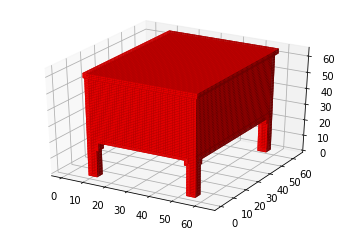

In [13]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(model.data,facecolors='red')
plt.show()